In [1]:
# Default logger of oemof
from oemof.tools import logger
from oemof import solph

import logging
import os
import pandas as pd
import pprint as pp

try:
    import matplotlib.pyplot as plt
except ImportError:
    plt = None

In [2]:
solver = "cbc"
debug = False  # Set number_of_timesteps to 3 to get a readable lp-file.
number_of_time_steps = 24 * 7 * 8
solver_verbose = False  # show/hide solver output

# initiate the logger (see the API docs for more information)
logger.define_logging(
    logfile="oemof_example.log",
    screen_level=logging.INFO,
    file_level=logging.DEBUG,
)
print(number_of_time_steps)

11:15:24-INFO-Path for logging: C:\Users\t2_ka\.oemof\log_files\oemof_example.log
1344


In [3]:
# setup an energy system
logging.info("Initialize the energy system")
date_time_index = pd.date_range(
    "1/1/2021", periods=number_of_time_steps, freq="H")

energysystem = solph.EnergySystem(timeindex=date_time_index)
print(date_time_index)

11:15:24-INFO-Initialize the energy system
DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               ...
               '2021-02-25 14:00:00', '2021-02-25 15:00:00',
               '2021-02-25 16:00:00', '2021-02-25 17:00:00',
               '2021-02-25 18:00:00', '2021-02-25 19:00:00',
               '2021-02-25 20:00:00', '2021-02-25 21:00:00',
               '2021-02-25 22:00:00', '2021-02-25 23:00:00'],
              dtype='datetime64[ns]', length=1344, freq='H')


In [4]:
# Read data file
filename = os.path.join(os.getcwd(), "basic_example_copy.csv")
data = pd.read_csv(filename)

In [5]:
# Create oemof objects bus, sink , source, transformer... 

logging.info("Create oemof objects")

# The bus objects were assigned to variables which makes it easier to connect
# components to these buses (see below).

# create influent bus
bsld = solph.Bus(label="sludge")

# create electricity bus
bel = solph.Bus(label="electricity")

# create slurry bus
bslu = solph.Bus(label="slurry")

# create effluent bus
beff = solph.Bus(label="effluent")

# create digested bus
bdig = solph.Bus(label="digested")

# create bio-gas bus
bbgas = solph.Bus(label="bio-gas")

# create heat bus
bheat = solph.Bus(label="heat")

# adding the buses to the energy system
energysystem.add(bsld,bel,bslu, beff, bdig, bbgas, bheat)

# create excess component for the bio-gas bus to allow overproduction
energysystem.add(solph.Sink(label="excess_bio-gas", inputs={bbgas: solph.Flow()}))

11:15:24-INFO-Create oemof objects


In [6]:
# create source object representing the natural gas commodity (annual limit)
#energysystem.add(
 #   solph.Source(
  #      label="rgas",
   #     outputs={bgas: solph.Flow(nominal_value=29825293, summed_max=1)},
    #)
#)

In [7]:
# create fixed source object representing domestic sewage
energysystem.add(
    solph.Source(
        label="wastewater",
        outputs={bsld: solph.Flow(fix=data["wastewater"], nominal_value=1000000)},
    )
)

# create fixed source object representing pv power plants
#energysystem.add(
 #   solph.Source(
  #      label="solidsludge",
   #     outputs={bel: solph.Flow(fix=data["solidsludge"], nominal_value=582000)},
    #)
#)

In [8]:
# create sink object representing the electrical demand
energysystem.add(
    solph.Sink(
        label="demand_el",
        inputs={bel: solph.Flow(fix=data["demand_el"], nominal_value=1)}, 
    )
)

# create sink object representing the thermal demand
energysystem.add(
    solph.Sink(
        label="demand_th",
        inputs={bheat: solph.Flow(fix=data["demand_th"], nominal_value=1)}, 
    )
)

# create sink object representing the water demand
energysystem.add(
    solph.Sink(
        label="demand_water",
        inputs={beff: solph.Flow(fix=data["demand_water"], nominal_value=1)}, 
    )
)

# create sink object representing the fertilizer demand
energysystem.add(
    solph.Sink(
        label="demand_f",
        inputs={bdig: solph.Flow(fix=data["demand_f"], nominal_value=1)}, 
    )
)

In [9]:
# create simple transformer object representing a gas power plant
energysystem.add(
    solph.Transformer(
        label="digester_gas",
        inputs={bsld: solph.Flow()},
        outputs={bbgas: solph.Flow(nominal_value=10e5, variable_costs=50)},
        conversion_factors={bbgas: 0.58},
    )
)

energysystem.add(
    solph.Transformer(
        label="CHP_el",
        inputs={bbgas: solph.Flow()},
        outputs={bel: solph.Flow(nominal_value=10e5, variable_costs=50)},
        conversion_factors={bel: 0.58},
    )
)

energysystem.add(
    solph.Transformer(
        label="CHP_th",
        inputs={bbgas: solph.Flow()},
        outputs={bheat: solph.Flow(nominal_value=10e4, variable_costs=70)},
        conversion_factors={bheat: 0.70},
    )
)

energysystem.add(
    solph.Transformer(
        label="digester_slu",
        inputs={bsld: solph.Flow()},
        outputs={bslu: solph.Flow(nominal_value=10e4, variable_costs=60)},
        conversion_factors={bslu: 0.42},
    )
)

energysystem.add(
    solph.Transformer(
        label="dewatering_dig",
        inputs={bslu: solph.Flow()},
        outputs={bdig: solph.Flow(nominal_value=10e2, variable_costs=60)},
        conversion_factors={bdig: 0.42},
    )
)

energysystem.add(
    solph.Transformer(
        label="dewatering_eff",
        inputs={bslu: solph.Flow()},
        outputs={beff: solph.Flow(nominal_value=10e2, variable_costs=60)},
        conversion_factors={beff: 0.30},
    )
)

energysystem.add(
    solph.Transformer(
        label="cw",
        inputs={beff: solph.Flow()},
        outputs={beff: solph.Flow(nominal_value=10e2, variable_costs=50)},
        conversion_factors={beff: 0.6},
    )
)

In [10]:
# create storage object representing a battery
storage = solph.components.GenericStorage(
    nominal_storage_capacity=10077997,
    label="ch4_storage",
    inputs={bbgas: solph.Flow(nominal_value=10077997 / 6)},
    outputs={
        bbgas: solph.Flow(nominal_value=10077997 / 6, variable_costs=0.001)
    },
    loss_rate=0.00,
    initial_storage_level=None,
    inflow_conversion_factor=1,
    outflow_conversion_factor=0.8,
)

energysystem.add(storage)

11:15:24-INFO-Optimise the energy system
11:15:27-INFO-Solve the optimization problem
11:15:32-INFO-Optimization successful...
11:15:32-INFO-Store the energy system with the results.
11:15:33-INFO-**** The script can be divided into two parts here.
11:15:33-INFO-Restore the energy system and the results.
11:15:33-INFO-Restoring attributes will overwrite existing attributes.

********* State of Charge (slice) *********
Empty DataFrame
Columns: [storage_content]
Index: []



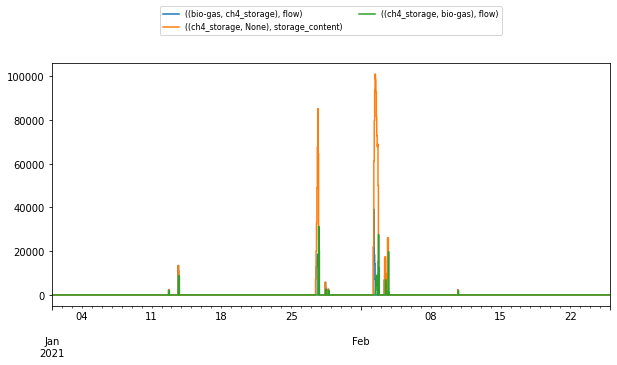

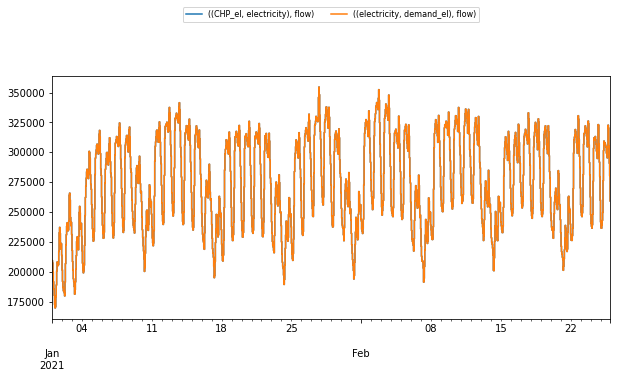

********* Meta results *********
{'objective': 57437121370.39152,
 'problem': {'Lower bound': 57437121370.0,
             'Name': 'unknown',
             'Number of constraints': 20162,
             'Number of nonzeros': 1344,
             'Number of objectives': 1,
             'Number of variables': 24194,
             'Sense': <ProblemSense.minimize: 'minimize'>,
             'Upper bound': 57437121370.0},
 'solver': {'Error rc': 0,
            'Statistics': {'Black box': {'Number of function evaluations': <pyomo.opt.results.container.ScalarData object at 0x000001A8F5700370>,
                                         'Number of gradient evaluations': <pyomo.opt.results.container.ScalarData object at 0x000001A8F57003A0>,
                                         'Number of iterations': <pyomo.opt.results.container.ScalarData object at 0x000001A8F57003D0>},
                           'Branch and bound': {'Number of bounded subproblems': <pyomo.opt.results.container.ScalarData object at 

In [11]:
##########################################################################
# Optimise the energy system and plot the results
##########################################################################

logging.info("Optimise the energy system")

# initialise the operational model
model = solph.Model(energysystem)

# This is for debugging only. It is not(!) necessary to solve the problem and
# should be set to False to save time and disc space in normal use. For
# debugging the timesteps should be set to 3, to increase the readability of
# the lp-file.
if debug:
    filename = os.path.join(
        solph.helpers.extend_basic_path("lp_files"), "basic_example.lp"
    )
    logging.info("Store lp-file in {0}.".format(filename))
    model.write(filename, io_options={"symbolic_solver_labels": True})

# if tee_switch is true solver messages will be displayed
logging.info("Solve the optimization problem")
model.solve(solver=solver, solve_kwargs={"tee": solver_verbose})

logging.info("Store the energy system with the results.")

# The processing module of the outputlib can be used to extract the results
# from the model transfer them into a homogeneous structured dictionary.

# add results to the energy system to make it possible to store them.
energysystem.results["main"] = solph.processing.results(model)
energysystem.results["meta"] = solph.processing.meta_results(model)

# The default path is the '.oemof' folder in your $HOME directory.
# The default filename is 'es_dump.oemof'.
# You can omit the attributes (as None is the default value) for testing cases.
# You should use unique names/folders for valuable results to avoid
# overwriting.

# store energy system with results
energysystem.dump(dpath=None, filename=None)

# ****************************************************************************
# ********** PART 2 - Processing the results *********************************
# ****************************************************************************

logging.info("**** The script can be divided into two parts here.")
logging.info("Restore the energy system and the results.")
energysystem = solph.EnergySystem()
energysystem.restore(dpath=None, filename=None)

# define an alias for shorter calls below (optional)
results = energysystem.results["main"]
storage = energysystem.groups["ch4_storage"]

# print a time slice of the state of charge
print("")
print("********* State of Charge (slice) *********")
print(
    results[(storage, None)]["sequences"][
        "2012-02-25 08:00:00":"2012-02-26 15:00:00"
    ]
)
print("")

# get all variables of a specific component/bus
custom_storage = solph.views.node(results, "ch4_storage")
electricity_bus = solph.views.node(results, "electricity")
digested_bus = solph.views.node(results, "digested")

# plot the time series (sequences) of a specific component/bus
if plt is not None:
    fig, ax = plt.subplots(figsize=(10, 5))
    custom_storage["sequences"].plot(
        ax=ax, kind="line", drawstyle="steps-post"
    )
    plt.legend(
        loc="upper center",
        prop={"size": 8},
        bbox_to_anchor=(0.5, 1.25),
        ncol=2,
    )
    fig.subplots_adjust(top=0.8)
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 5))
    electricity_bus["sequences"].plot(
        ax=ax, kind="line", drawstyle="steps-post"
    )
    plt.legend(
        loc="upper center", prop={"size": 8}, bbox_to_anchor=(0.5, 1.3), ncol=2
    )
    fig.subplots_adjust(top=0.8)
    plt.show()

# print the solver results
print("********* Meta results *********")
pp.pprint(energysystem.results["meta"])
print("")

# print the sums of the flows around the electricity bus
print("********* Main results *********")
print(electricity_bus["sequences"].sum(axis=0))
print(digested_bus["sequences"].sum(axis=0))
print(custom_storage["sequences"].sum(axis=0))